In [2]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 9.6 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [46]:
import os
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk import word_tokenize
from collections import Counter
from torch.autograd import Variable
import seaborn as sns
import matplotlib.pyplot as plt

# init parameters
UNK = 0  # unknow word-id
PAD = 1  # padding word-id
BATCH_SIZE = 64

DEBUG = False    # Debug / Learning Purposes.
# DEBUG = False # Build the model, better with GPU CUDA enabled.

if DEBUG:
    EPOCHS  = 2
    LAYERS  = 3
    H_NUM   = 8
    D_MODEL = 128
    D_FF    = 256
    DROPOUT = 0.1
    MAX_LENGTH = 60
    TRAIN_FILE = 'data/yue-eng2.txt'
    DEV_FILE   = 'data/yue-eng.txt'
    SAVE_FILE  = 'save/models/model.pt'
else:
    EPOCHS  = 20
    LAYERS  = 6
    H_NUM   = 8
    D_MODEL = 256
    D_FF    = 1024
    DROPOUT = 0.1
    MAX_LENGTH = 60
    TRAIN_FILE = 'data/yue-eng2.txt'
    DEV_FILE   = 'data/yue-eng.txt'
    SAVE_FILE  = 'save/models/large_model.pt'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
def seq_padding(X, padding=0):
    """
    add padding to a batch data
    """
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])

class PrepareData:
    def __init__(self, train_file, dev_file):
        # 01. Read the data and tokenize
        self.train_en, self.train_cn = self.load_data(train_file)
        self.dev_en, self.dev_cn     = self.load_data(dev_file)

        # 02. build dictionary: English and Chinese
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = self.build_dict(self.train_cn)

        # 03. word to id by dictionary Use input word list length to sort, reduce padding
        self.train_en, self.train_cn = self.wordToID(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn     = self.wordToID(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)

        # 04. batch + padding + mask
        self.train_data = self.splitBatch(self.train_en, self.train_cn, BATCH_SIZE)
        self.dev_data   = self.splitBatch(self.dev_en, self.dev_cn, BATCH_SIZE)

    def load_data(self, path):
        """
        Read English and Chinese Data
        tokenize the sentence and add start/end marks(Begin of Sentence; End of Sentence)
        en = [['BOS', 'i', 'love', 'you', 'EOS'],
              ['BOS', 'me', 'too', 'EOS'], ...]
        cn = [['BOS', '我', '爱', '你', 'EOS'],
              ['BOS', '我', '也', '是', 'EOS'], ...]
        """
        en = []
        cn = []
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip().split('\t')
                en.append(["BOS"] + word_tokenize(line[0].lower()) + ["EOS"])
                cn.append(["BOS"] + word_tokenize(" ".join([w for w in line[1]])) + ["EOS"])
        return en, cn

    def build_dict(self, sentences, max_words = 50000):
        """
        sentences: list of word list
        build dictonary as {key(word): value(id)}
        """
        word_count = Counter()
        for sentence in sentences:
            for s in sentence:
                word_count[s] += 1

        ls = word_count.most_common(max_words)
        total_words = len(ls) + 2
        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)}
        word_dict['UNK'] = UNK
        word_dict['PAD'] = PAD
        # inverted index: {key(id): value(word)}
        index_dict = {v: k for k, v in word_dict.items()}
        return word_dict, total_words, index_dict

    def wordToID(self, en, cn, en_dict, cn_dict, sort=True):
        """
        convert input/output word lists to id lists.
        Use input word list length to sort, reduce padding.
        """
        length = len(en)
        out_en_ids = [[en_dict.get(w, 0) for w in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(w, 0) for w in sent] for sent in cn]

        def len_argsort(seq):
            """
            get sorted index w.r.t length.
            """
            return sorted(range(len(seq)), key=lambda x: len(seq[x]))

        if sort: # update index
            sorted_index = len_argsort(out_en_ids) # English
            out_en_ids = [out_en_ids[id] for id in sorted_index]
            out_cn_ids = [out_cn_ids[id] for id in sorted_index]
        return out_en_ids, out_cn_ids

    def splitBatch(self, en, cn, batch_size, shuffle=True):
        """
        get data into batches
        """
        idx_list = np.arange(0, len(en), batch_size)
        if shuffle:
            np.random.shuffle(idx_list)

        batch_indexs = []
        for idx in idx_list:
            batch_indexs.append(np.arange(idx, min(idx + batch_size, len(en))))

        batches = []
        for batch_index in batch_indexs:
            batch_en = [en[index] for index in batch_index]
            batch_cn = [cn[index] for index in batch_index]
            # paddings: batch, batch_size, batch_MaxLength
            batch_cn = seq_padding(batch_cn)
            batch_en = seq_padding(batch_en)
            batches.append(Batch(batch_en, batch_cn))
            #!!! 'Batch' Class is called here but defined in later section.
        return batches

In [48]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # return x's embedding vector（times math.sqrt(d_model)）
        return self.lut(x) * math.sqrt(self.d_model)

In [49]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model, device=DEVICE)
        position = torch.arange(0., max_len, device=DEVICE).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2, device=DEVICE) * -(math.log(10000.0) / d_model))
        pe_pos   = torch.mul(position, div_term)
        pe[:, 0::2] = torch.sin(pe_pos)
        pe[:, 1::2] = torch.cos(pe_pos)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe) # pe

    def forward(self, x):
        #  build pe w.r.t to the max_length
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

Text(95.72222222222221, 0.5, 'sequence length')

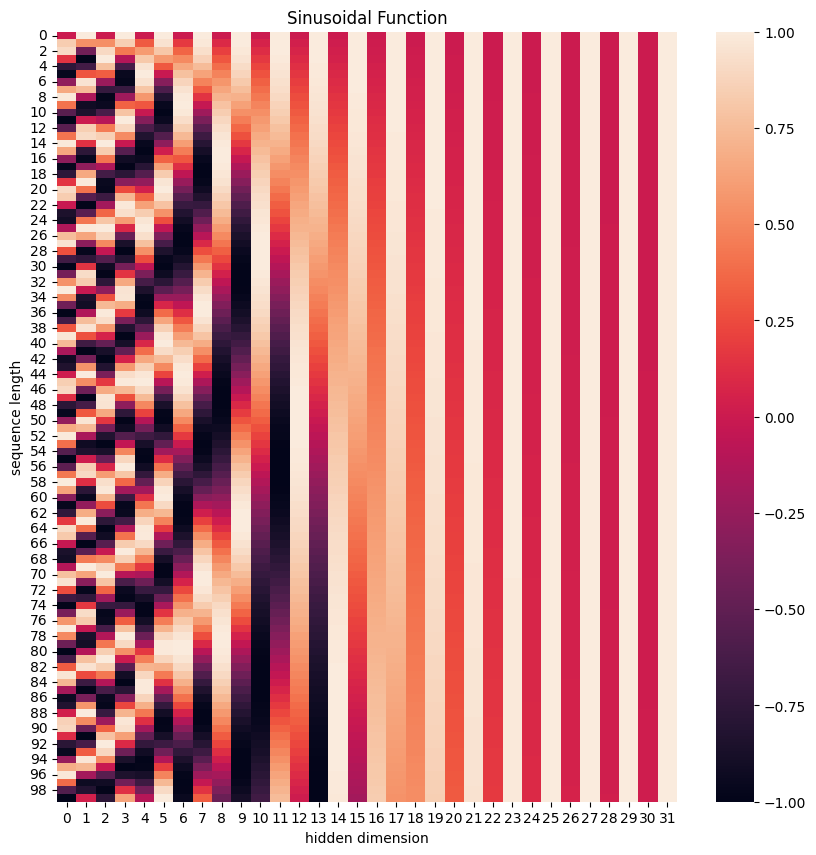

In [50]:
pe = PositionalEncoding(32, 0, 100)  # d_model, dropout-ratio, max_len
positional_encoding = pe.forward(Variable(torch.zeros(1, 100, 32))) # sequence length, d_model
plt.figure(figsize=(10,10))
sns.heatmap(positional_encoding.squeeze()) # 100x32 matrix
plt.title("Sinusoidal Function")
plt.xlabel("hidden dimension")
plt.ylabel("sequence length")

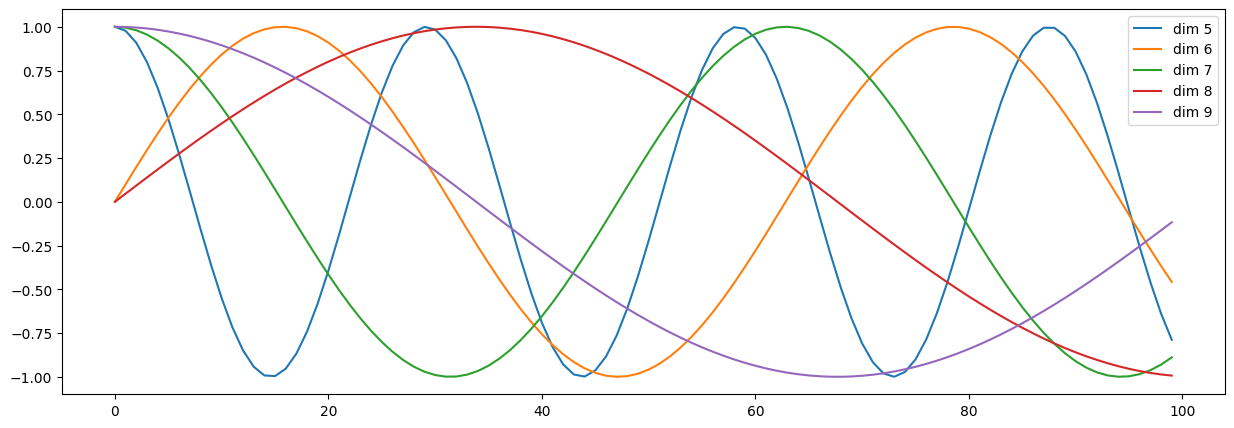

In [51]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(24, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 24)))
plt.plot(np.arange(100), y[0, :, 5:10].data.numpy())
plt.legend(["dim %d"%p for p in [5,6,7,8,9]])

In [52]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [53]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0 # check the h number
        self.d_k = d_model // h
        self.h = h
        # 4 linear layers: WQ WK WV and final linear mapping WO
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0) # get batch size
        # 1) Do all the linear projections in batch from d_model => h x d_k
        # parttion into h sections，switch 2,3 axis for computation.
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x) # final linear layer

In [54]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        # convert words id to long format.
        src = torch.from_numpy(src).to(DEVICE).long()
        trg = torch.from_numpy(trg).to(DEVICE).long()
        self.src = src
        # get the padding postion binary mask
        # change the matrix shape to  1×seq.length
        self.src_mask = (src != pad).unsqueeze(-2)
        # if target is not empty, mask decoder target.
        if trg is not None:
            # decoder input from target
            self.trg = trg[:, :-1]
            # decoder target from trg
            self.trg_y = trg[:, 1:]
            # add attention mask to decoder input
            self.trg_mask = self.make_std_mask(self.trg, pad)
            # check decoder output padding number
            self.ntokens = (self.trg_y != pad).data.sum()

    # Mask
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask # subsequent_mask is defined in 'decoder' section.

In [55]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True) # rows
        std = x.std(-1, keepdim=True)
        x_zscore = (x - mean)/ torch.sqrt(std ** 2 + self.eps)
        return self.a_2*x_zscore+self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    SublayerConnection: connect Multi-Head Attention and Feed Forward Layers
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [56]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h1 = self.w_1(x)
        h2 = self.dropout(h1)
        return self.w_2(h2)

In [57]:
def clones(module, N):
    """
    "Produce N identical layers. N=6 in the original paper."
    Use deepcopy the weight are indenpendent.
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    "Core encoder is a stack of N layers (blocks)"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """
        Pass the input (and mask) through each layer in turn.
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# Each Encoder Block contains two sub-layers(Self-Attention,Position-wise) and 2 sublayer-connetions:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size # d_model

    def forward(self, x, mask):
        # X-embedding to Multi-head-Attention
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # X-embedding to feed-forwad nn
        return self.sublayer[1](x, self.feed_forward)

In [58]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        "Generic N layer decoder with masking."
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        Repeat decoder N times
        Decoderlayer get a input attention mask (src)
        and a output attention mask (tgt) + subsequent mask
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory # encoder output embedding
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        # Context-Attention：q=decoder hidden，k,v from encoder hidden
        return self.sublayer[2](x, self.feed_forward)

In [59]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

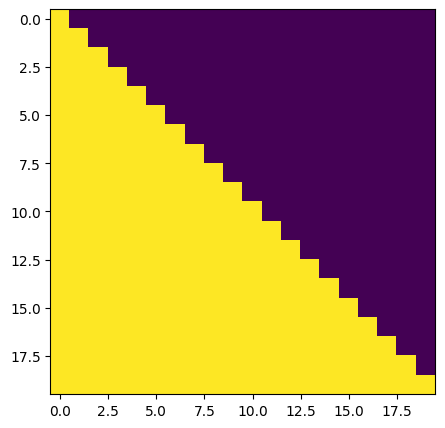

In [60]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

In [61]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        # encoder output will be the decoder's memory for decoding
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # decode: d_model to vocab mapping
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [62]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h = 8, dropout=0.1):
    c = copy.deepcopy
    #  Attention
    attn = MultiHeadedAttention(h, d_model).to(DEVICE)
    #  FeedForward
    ff = PositionwiseFeedForward(d_model, d_ff, dropout).to(DEVICE)
    #  Positional Encoding
    position = PositionalEncoding(d_model, dropout).to(DEVICE)
    #  Transformer
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        nn.Sequential(Embeddings(d_model, src_vocab).to(DEVICE), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(DEVICE), c(position)),
        Generator(d_model, tgt_vocab)).to(DEVICE)

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    # Paper title: Understanding the difficulty of training deep feedforward neural networks Xavier
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model.to(DEVICE)

In [63]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum') # 2020 update
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

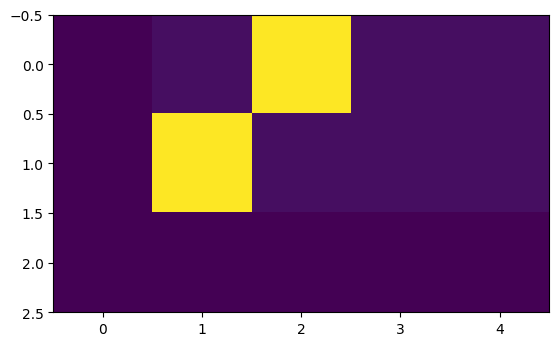

In [64]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.1)  #  ϵ=0.4
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), Variable(torch.LongTensor([2, 1, 0])))
# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

In [65]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float()

In [66]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

# We used factor=2, warmup-step = 4000
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

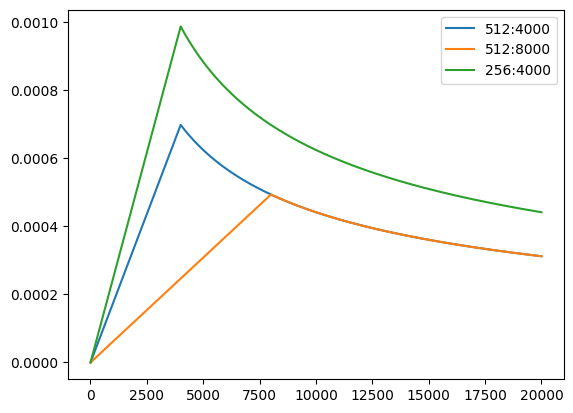

In [67]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [68]:
def run_epoch(data, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0.
    total_loss = 0.
    tokens = 0.
    for i , batch in enumerate(data):
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch {:d} Batch: {:d} Loss: {:.4f} Tokens per Sec: {:.2f}s".format(epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

def train(data, model, criterion, optimizer):
    """
    Train and Save the model.
    """
    # init loss as a large value
    best_dev_loss = 1e5

    for epoch in range(EPOCHS):
        # Train model
        model.train()
        run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)
        model.eval()

        # validate model on dev dataset
        print('>>>>> Evaluate')
        dev_loss = run_epoch(data.dev_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        print('<<<<< Evaluate loss: {:.2f}'.format(dev_loss))

        # save the model with best-dev-loss (model validation)
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            torch.save(model.state_dict(), SAVE_FILE) # SAVE_FILE = 'save/model.pt'
        print(f">>>>> current best loss: {best_dev_loss}")

In [69]:
# Step 1: Data Preprocessing
data = PrepareData(TRAIN_FILE, DEV_FILE)
src_vocab = len(data.en_word_dict)
tgt_vocab = len(data.cn_word_dict)
print(f"src_vocab {src_vocab}")
print(f"tgt_vocab {tgt_vocab}")

# Step 2: Init model
model = make_model(
                    src_vocab,
                    tgt_vocab,
                    LAYERS,
                    D_MODEL,
                    D_FF,
                    H_NUM,
                    DROPOUT
                )

# Step 3: Training model
print(">>>>>>> start train")
train_start = time.time()
criterion = LabelSmoothing(tgt_vocab, padding_idx = 0, smoothing= 0.0)
optimizer = NoamOpt(D_MODEL, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9,0.98), eps=1e-9))

train(data, model, criterion, optimizer)
print(f"<<<<<<< finished train, cost {time.time()-train_start:.4f} seconds")

src_vocab 10456
tgt_vocab 3355
>>>>>>> start train
Epoch 0 Batch: 0 Loss: 8.1798 Tokens per Sec: 2.02s
Epoch 0 Batch: 50 Loss: 7.0154 Tokens per Sec: 1.83s
Epoch 0 Batch: 100 Loss: 6.9280 Tokens per Sec: 1.80s
Epoch 0 Batch: 150 Loss: 6.0428 Tokens per Sec: 1.85s
Epoch 0 Batch: 200 Loss: 5.6649 Tokens per Sec: 1.81s
>>>>> Evaluate
Epoch 0 Batch: 0 Loss: 5.1745 Tokens per Sec: 1.75s
Epoch 0 Batch: 50 Loss: 5.2796 Tokens per Sec: 2.10s
<<<<< Evaluate loss: 5.43
>>>>> current best loss: 5.432232856750488
Epoch 1 Batch: 0 Loss: 5.7745 Tokens per Sec: 1.99s
Epoch 1 Batch: 50 Loss: 4.9981 Tokens per Sec: 1.75s
Epoch 1 Batch: 100 Loss: 5.6750 Tokens per Sec: 1.73s
Epoch 1 Batch: 150 Loss: 5.3535 Tokens per Sec: 1.82s
Epoch 1 Batch: 200 Loss: 5.3927 Tokens per Sec: 1.80s
>>>>> Evaluate
Epoch 1 Batch: 0 Loss: 4.8183 Tokens per Sec: 1.76s
Epoch 1 Batch: 50 Loss: 5.0942 Tokens per Sec: 2.09s
<<<<< Evaluate loss: 5.16
>>>>> current best loss: 5.1617937088012695
Epoch 2 Batch: 0 Loss: 5.5074 Tokens

In [71]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    Translate src with model
    """
    # decode the src
    memory = model.encode(src, src_mask)
    # init 1×1 tensor as prediction，fill in ('BOS')id, type: (LongTensor)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    #  run the length of the sentence
    for i in range(max_len-1):
        # decode one by one
        out = model.decode(memory,
                           src_mask,
                           Variable(ys),
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        #  out to log_softmax
        prob = model.generator(out[:, -1])
        #  get the max-prob id
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        #  concatenate with early predictions
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

def evaluate(data, model):
    """
    Make prediction with trained model, and print results.
    """
    with torch.no_grad():
        #  pick some random sentences from our data format.
        #  here I used 10 sentences from data.dev-en.
        #  you can easily modify this function from new input.
        for i in np.random.randint(len(data.dev_en), size=10):
            # Print English sentence
            en_sent = " ".join([data.en_index_dict[w] for w in data.dev_en[i]]) # space between English words
            print("\n" + en_sent)

            # Print Target Chinese sentence
            cn_sent =  " ".join([data.cn_index_dict[w] for w in data.dev_cn[i]]) # no space in Chinese words
            print("".join(cn_sent))

            # conver English to tensor
            src = torch.from_numpy(np.array(data.dev_en[i])).long().to(DEVICE)
            src = src.unsqueeze(0)
            # set attention mask
            src_mask = (src != 0).unsqueeze(-2)
            # apply model to decode, make prediction
            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])
            # save all in the translation list
            translation = []
            # convert id to Chinese, skip 'BOS' 0.
            for j in range(1, out.size(1)):
                sym = data.cn_index_dict[out[0, j].item()]
                if sym != 'EOS':
                    translation.append(sym)
                else:
                    break
            print("translation: {}".format(" ".join(translation)))

In [72]:
# Predition
model.load_state_dict(torch.load(SAVE_FILE))
print(">>>>>>> start evaluate")
evaluate_start  = time.time()
evaluate(data, model)
print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")

>>>>>>> start evaluate

BOS today is my friend 's birthday . EOS
BOS 我 朋 友 今 日 生 日 。 EOS
translation: 今 日 我 同 朋 友 打 𠵿 牌 。

BOS how hot would you like your curry ? `` make it as UNK as you can ! '' EOS
BOS 「 請 問 咖 喱 要 咩 辣 ？ 」 「 有 幾 辣 得 幾 辣 ！ 」 EOS
translation: 你 哋 有 乜 嘢 事 啊 ？ 你 有 乜 睇 啊 ？

BOS will you come with me to the concert ? EOS
BOS 你 同 唔 同 我 一 齊 去 聽 音 樂 會 呀 ？ EOS
translation: 你 有 冇 同 我 𠸎 耕 ？

BOS you are always complaining about your husband . EOS
BOS 你 成 日 都 喺 度 話 你 個 老 公 呢 樣 唔 好 嗰 樣 唔 好 。 EOS
translation: 你 老 豆 係 老 細 嘅 仔 。

BOS can you read this UNK ? EOS
BOS 你 識 唔 識 讀 呢 個 漢 字 呀 ？ EOS
translation: 你 點 解 呢 啲 書 有 乜 嘢 餸 啊 ？

BOS they always wake up early , even on sundays . EOS
BOS 佢 哋 成 日 好 早 起 身 ， 連 星 期 日 都 。 EOS
translation: 佢 哋 都 係 老 師 ， 不 過 我 哋 都 好 鍾 意 。

BOS they 've been trained . EOS
BOS 佢 哋 受 過 訓 練 。 EOS
translation: 佢 哋 跑 步 跑 步 跑 步 。

BOS it is no use arguing with him . EOS
BOS 同 佢 拗 嚟 都 嘥 氣 。 EOS
translation: 嗰 個 人 都 冇 得 閒 佢 嚟 㗎 。

BOS let me help you with the dishes . 

In [73]:
# Here is my pretrained model with CUDA support
if DEVICE=="cuda":
    SAVE_FILE_EXTRA  = 'save/models/large_model.pt'
    model.load_state_dict(torch.load(SAVE_FILE_EXTRA))
    print(">>>>>>> start evaluate")
    evaluate_start  = time.time()
    evaluate(data, model)
    print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")


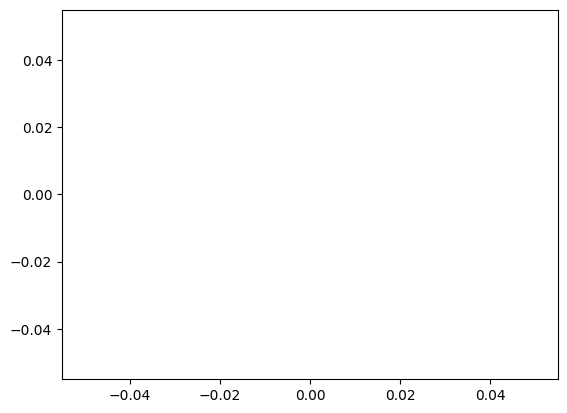

In [75]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).item()

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])